In [5]:
from sys import path

path.append("../")

from gc import collect as garbage_collect

from joblib import Parallel, delayed
from numpy import ndarray, stack
from pandas import DataFrame, Series, option_context as pandas_option_context
from tqdm.auto import tqdm
from lazypredict.Supervised import LazyClassifier

from src.feature_extraction.eda import get_eda_features
from src.utils.experiment_info import ExperimentInfo
from src.utils.io import load_processed_data
from src.utils.misc import get_all_users
from src.utils.plots import (
    make_biometrics_plots_together_matplotlib,
    plot_binary_labels,
)
from src.utils.segmentation import segment
from src.utils.misc import get_labels_counts
from src.ml import resampling, local_resampling
from src.ml.cv import run_cross_validation_prediction

from src.ml.loso import run_same_side_classifications, run_different_classifications

# Intro

In this notebook, I analyse the artefact data. The idea is to identify which users might have more artefacts, and if they coincide with users having lower performance during the ML part.

# Data Preparation

The artefacts scripts have been moved inside the EDA filtering.

## Cognitive Load Info

In [6]:
path_to_experiment_info: str = "../data.nosync/mwc2022/all_experimento_info.csv"
experiment_info = ExperimentInfo(path=path_to_experiment_info, mode=2)

## Physiological Data

In [16]:
eda_data_base_path: str = "../data.nosync/mwc2022/filtered_artifacts/*/EDA/*.parquet"
acc_data_base_path: str = "../data.nosync/mwc2022/filtered_artifacts/*/ACC/*.parquet"

artifacts_data = load_processed_data(path=eda_data_base_path, file_format="parquet")
garbage_collect()

Loading data:   0%|          | 0/19 [00:00<?, ?it/s]

21

In [19]:
from pandas import to_datetime, Timedelta, DatetimeIndex, MultiIndex


def correct_session_idx(session_name: str):
    session_time: str = session_name.split("-")[1]
    if session_time[0] == "0":
        session_id_corrected: Timestamp = to_datetime(
            session_name.split("-")[0], format="%y%m%d"
        )
    else:
        session_id_corrected: Timestamp = to_datetime(
            session_name.split("-")[0], format="%y%m%d"
        ) + Timedelta("1D")
    session_id_corrected: str = str(session_id_corrected.date())
    return session_id_corrected


def super_correct_session_idx(idx):
    correct = [correct_session_idx(el) for el in idx]
    if len(correct) > len(set(correct)):
        new_correct = []
        i = 0
        for el in correct:
            if el in new_correct:
                new_correct.append(el + f"_{i}")
                i += 1
            else:
                new_correct.append(el)
                i = 0
        correct = new_correct
    return correct


def correct_session_names(df: DataFrame):
    df.index = df.index.set_levels(
        super_correct_session_idx(df.index.levels[0]), level=0
    )
    return df


In [21]:
artifacts_data = {side: {
    user: correct_session_names(user_data)
    for user, user_data in tqdm(side_data.items(), desc='User progress')
}
for side, side_data in artifacts_data.items()}

User progress:   0%|          | 0/9 [00:00<?, ?it/s]

User progress:   0%|          | 0/10 [00:00<?, ?it/s]

In [28]:
test1 = artifacts_data['right']['U09']['Artifact']

In [25]:
eda_data_base_path: str = "../data.nosync/mwc2022/filtered/*/EDA/*.parquet"
acc_data_base_path: str = "../data.nosync/mwc2022/filtered/*/ACC/*.parquet"

eda_data = load_processed_data(path=eda_data_base_path, file_format="parquet")
garbage_collect()

Loading data:   0%|          | 0/19 [00:00<?, ?it/s]

653

In [38]:
test2 = eda_data['right']['U09']

In [40]:
import pandas as pd

old_second_level_idx = test2.index.levels[1]
test2.index = pd.MultiIndex.from_arrays(
    [test2.index.get_level_values(0), test2.groupby(level=0).cumcount()],
    names=['session', 'timestamp'])

pd.merge(test1, test2, how='right', right_index=True, left_index=True)

mixed-EDA  phasic-EDA
session    timestamp                       
2022-11-18 0              -0.87       -0.40
           1              -0.85       -0.40
           2              -0.84       -0.27
           3              -0.83       -0.13
           4              -0.83       -0.05
...                         ...         ...
2022-12-21 105751         -0.41       -0.26
           105752         -0.40       -0.27
           105753         -0.40       -0.27
           105754         -0.40       -0.27
           105755         -0.39       -0.28

[2736804 rows x 2 columns]

In [9]:
users_in_left_side = set(eda_data['left'].keys())
users_in_right_side = set(eda_data['right'].keys())
print(f"Number of users with both left and right hand data: {len(users_in_left_side & users_in_right_side)}")

Number of users with both left and right hand data: 8


## Segmentation

The segmentation will be performed over `baseline_1` and `cognitive_load` periods. Other baselines are not considered, since they were very short periods performed after some activity, one of which was cognitive load itself. As such, brian phenomena from those activites might propagate in the EDA signal and make the classification harded.

In [10]:
segment_size_in_mins = 10
segment_size_in_secs = segment_size_in_mins * 60
eda_sample_rate = 4
segment_size_in_sampling_rate: int = segment_size_in_secs * eda_sample_rate

experiment_info_as_dict = experiment_info.to_dict()

In [11]:
(
    values_left,
    values_right,
    labels_left,
    labels_right,
    groups_left,
    groups_right,
) = segment(
    data=eda_data,
    experiment_info_as_dict=experiment_info.to_dict(),
    segment_size_in_sampling_rate=segment_size_in_sampling_rate,
    segment_size_in_secs=segment_size_in_secs,
    data_sample_rate=eda_sample_rate,
    mode=experiment_info.get_mode(),
)

User progress:   0%|          | 0/8 [00:00<?, ?it/s]

In [19]:
experiment_info.to_dict()['U09']

index             bed_time latency  \
participant_id Date                                             
U09            2022-11-20    239  2022-11-20 01:45:00      15   
               2022-11-18    235  2022-11-18 00:15:00      15   
               2022-11-27    253  2022-11-27 03:05:00      10   
               2022-11-29    257  2022-11-29 23:42:00      30   
               2022-11-28    255  2022-11-28 00:33:00      21   
               2022-11-19    237  2022-11-19 00:55:00       5   
               2022-11-26    251  2022-11-26 01:20:00      35   
               2022-11-21    241  2022-11-21 01:40:00      40   
               2022-12-15    265  2022-12-15 23:34:00      10   
               2022-12-13    261  2022-12-13 01:20:00      10   
               2022-12-14    263  2022-12-14 23:25:00       5   
               2022-11-24    247  2022-11-24 00:45:00      25   
               2022-11-23    245  2022-11-23 23:00:00      15   
               2022-11-22    243  2022-11-22 23:45:00       5   
               2022-11-25    249  2022-11-25 23:25:00      10   
               2022-12-20    275  2022-12-20 00:48:00       5   
               2022-12-18    271  2022-12-18 03:43:00       2   
               2022-12-11    259  2022-12-11 00:45:00      20   
               2022-12-16    267  2022-12-16 00:00:00       5   
               2022-12-17    269  2022-12-17 01:26:00       4   
               2022-12-19    273  2022-12-19 01:07:00       5   
               2022-12-21    277  2022-12-21 23:52:00       2   

                                       wake_up_time awakening  \
participant_id Date                                             
U09            2022-11-20 2022-11-20 08:45:00+01:00         1   
               2022-11-18 2022-11-18 07:38:00+01:00         2   
               2022-11-27 2022-11-27 09:43:00+01:00         0   
               2022-11-29 2022-11-29 07:45:00+01:00         0   
               2022-11-28 2022-11-28 08:08:00+01:00         0   
               2022-11-19 2022-11-19 09:03:00+01:00         0   
               2022-11-26 2022-11-26 09:12:00+01:00         0   
               2022-11-21 2022-11-21 08:20:00+01:00         0   
               2022-12-15 2022-12-15 08:23:00+01:00         0   
               2022-12-13 2022-12-13 09:20:00+01:00         0   
               2022-12-14 2022-12-14 06:50:00+01:00         0   
               2022-11-24 2022-11-24 08:12:00+01:00         0   
               2022-11-23 2022-11-23 07:25:00+01:00         0   
               2022-11-22 2022-11-22 09:30:00+01:00         1   
               2022-11-25 2022-11-25 06:38:00+01:00         0   
               2022-12-20 2022-12-20 08:17:00+01:00         0   
               2022-12-18 2022-12-18 10:03:00+01:00         0   
               2022-12-11 2022-12-11 10:11:00+01:00         0   
               2022-12-16 2022-12-16 06:52:00+01:00         0   
               2022-12-17 2022-12-17 09:11:00+01:00         0   
               2022-12-19 2022-12-19 09:30:00+01:00         0   
               2022-12-21 2022-12-21 06:20:00+01:00         0   

                          awakening_duration  disturbance_reasons  recovery  \
participant_id Date                                                           
U09            2022-11-20                  2                  NaN      6.00   
               2022-11-18                  2  feeling too hot (2)      7.00   
               2022-11-27                  0                  NaN      6.00   
               2022-11-29                  0                  NaN      6.00   
               2022-11-28                  0                  NaN      7.00   
               2022-11-19                  0                  NaN      5.00   
               2022-11-26                  0                  NaN      7.00   
               2022-11-21                  0                  NaN      7.00   
               2022-12-15                  0                  NaN      7.00   
               2022-12-13           

In [17]:
import pandas as pd
eda_data['right']['U09'].loc[pd.IndexSlice['221117-224421']]

mixed-EDA  phasic-EDA  \
session       timestamp                                                 
221117-224421 2022-11-17 23:44:21+01:00             -0.00        0.00   
              2022-11-17 23:44:21.250000+01:00       0.04        0.00   
              2022-11-17 23:44:21.500000+01:00       0.08        0.01   
              2022-11-17 23:44:21.750000+01:00       0.09        0.03   
              2022-11-17 23:44:22+01:00              0.10        0.04   
...                                                   ...         ...   
221220-221639 2022-12-21 06:37:12.750000+01:00       0.19        0.00   
              2022-12-21 06:37:13+01:00              0.19        0.00   
              2022-12-21 06:37:13.250000+01:00       0.19        0.00   
              2022-12-21 06:37:13.500000+01:00       0.19        0.00   
              2022-12-21 06:37:13.750000+01:00       0.19        0.00   

                                                Artifact  
session       timestamp                                   
221117-224421 2022-11-17 23:44:21+01:00             1.00  
              2022-11-17 23:44:21.250000+01:00      0.00  
              2022-11-17 23:44:21.500000+01:00      0.00  
              2022-11-17 23:44:21.750000+01:00      0.00  
              2022-11-17 23:44:22+01:00             0.00  
...                                                  ...  
221220-221639 2022-12-21 06:37:12.750000+01:00      0.00  
              2022-12-21 06:37:13+01:00             0.00  
              2022-12-21 06:37:13.250000+01:00      0.00  
              2022-12-21 06:37:13.500000+01:00      0.00  
              2022-12-21 06:37:13.750000+01:00      0.00  

[2736580 rows x 3 columns]

The distribution is almost balanced: as such, re-balancing should not be a large problem.

## Artefact Removal

In the previous notebook, the training of the model was done without regard for possible artefacts, present in the data. However, it is quite easy to have artefact in EDA data. As such, to methods shall be proposed here for artefact removal.

1. Using Shkurta's method (see https://github.com/shkurtagashi/EDArtifact)
2. Using a simple acc-based logic. The threshold will be decided upon visual inspection and looking at similar literature.

Both methods have been implemented inside the EDA filtering scripts. (only 1 at the moment, but second will follow soon)

## Feature Extraction

In [24]:
features_left = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_left)
)
features_right = Parallel(n_jobs=-1)(
    delayed(get_eda_features)(value) for value in (values_right)
)

features_left: ndarray = stack(features_left)
features_right: ndarray = stack(features_right)

labels_left: ndarray = stack(labels_left)
labels_right: ndarray = stack(labels_right)

groups_left: ndarray = stack(groups_left)
groups_right: ndarray = stack(groups_right)

artefacts_left: ndarray = stack(artefacts_left)
artefacts_right: ndarray = stack(artefacts_right)


ValueError: need at least one array to stack

In [9]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")
print(f"{artefacts_left.shape=}")

features_left.shape=(864, 11)
labels_left.shape=(864,)
groups_left.shape=(864,)
artefacts_left.shape=(864,)


# Artefact Analysis

In [10]:
eda_features_names: list[str] = [
    "min_feat",
    "max_feat",
    "mean_feat",
    "std_feat",
    "dynamic_range_feat",
    "slope_feat",
    "absolute_slope_feat",
    "first_derivetive_mean_feat",
    "first_derivative_std_feat",
    "number_of_peaks_feat",
    "peaks_amplitude_feat",
]

In [25]:
data_left = DataFrame(features_left, columns=eda_features_names)
data_left['artefact'] = artefacts_left
data_left['artefact'] = data_left['artefact'].astype(bool)
data_left['user'] = groups_left
data_left['label'] = labels_left
data_left['label'] = data_left['label'].apply(lambda x: 'relaxation' if x == 0 else 'cognitive load')

data_right = DataFrame(features_right, columns=eda_features_names)
data_right['artefact'] = artefacts_right
data_right['artefact'] = data_right['artefact'].astype(bool)
data_right['user'] = groups_right
data_right['label'] = labels_right
data_right['label'] = data_right['label'].apply(lambda x: 'relaxation' if x == 0 else 'cognitive load')

In [27]:
def total_percentage_artefact(x: DataFrame) -> DataFrame:
    tot_artefacts = x['artefact'].sum()
    tot_elements = x.shape[0]
    return tot_artefacts / tot_elements

artefact_removed_percent_left = data_left.groupby('user').apply(total_percentage_artefact)
artefact_removed_percent_right = data_right.groupby('user').apply(total_percentage_artefact)

artefact_removed_percent = artefact_removed_percent_left.to_frame(name='artefact_removed_percent')
artefact_removed_percent['side'] = 'left'
artefact_removed_percent = artefact_removed_percent.append(artefact_removed_percent_right.to_frame(name='artefact_removed_percent').assign(side='right'))

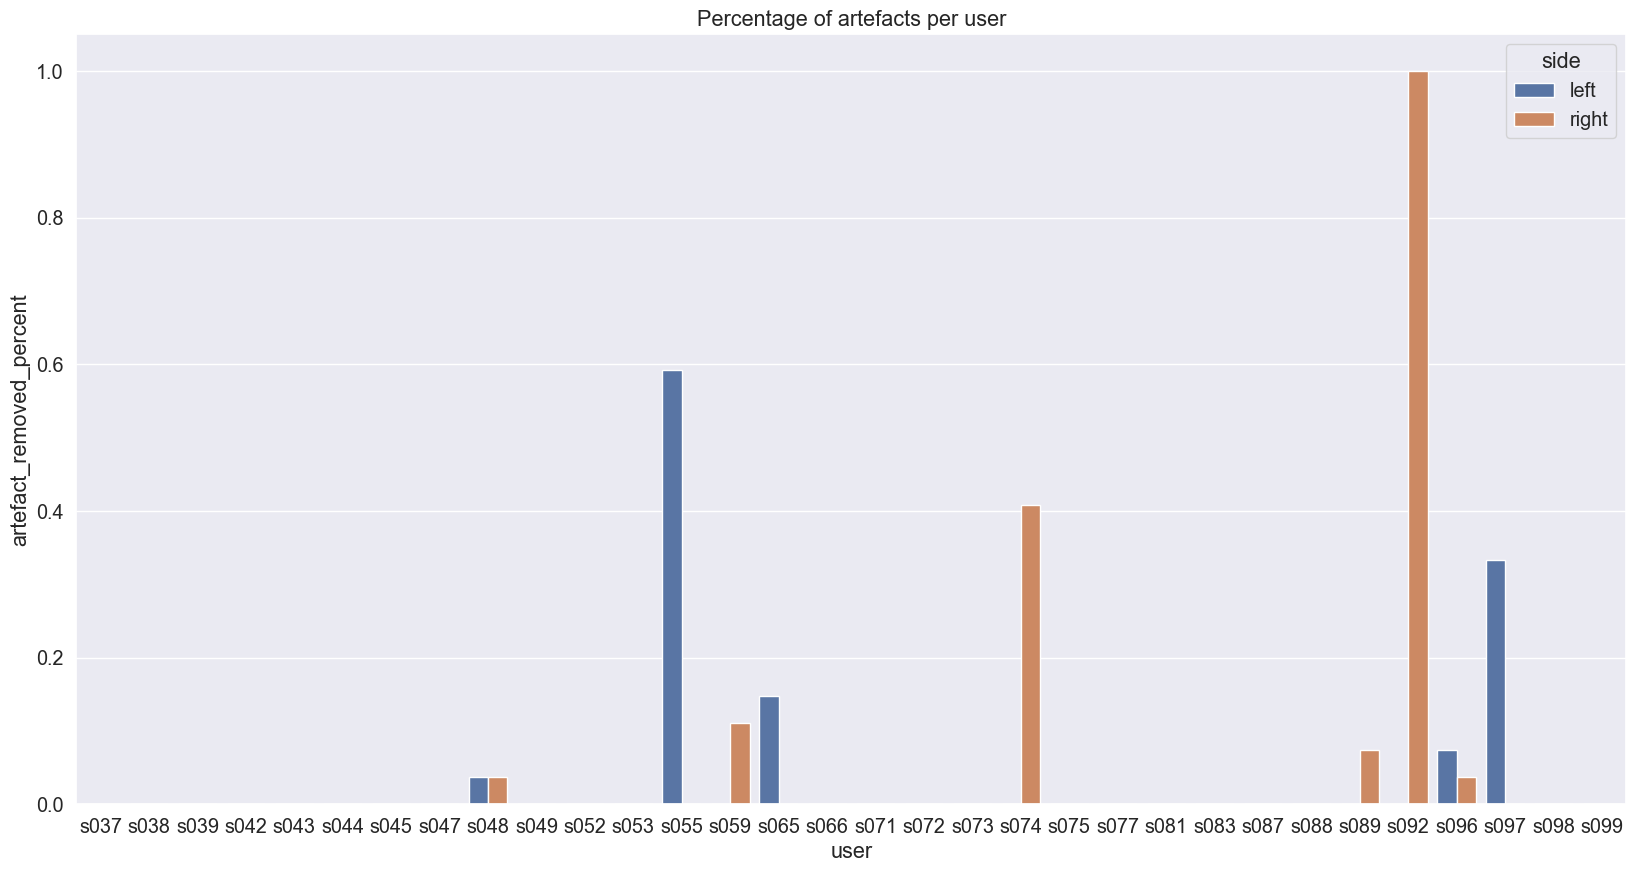

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

ax = sns.barplot(data=artefact_removed_percent, x=artefact_removed_percent.index, y='artefact_removed_percent', hue=artefact_removed_percent['side'])
plt.title("Percentage of artefacts per user")
# add minor gridlines for vertical axes
ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=2, color='black', alpha=0.2)
plt.show()

### Artefact Removal

In [21]:
features_left = features_left[~artefacts_left.astype(bool)]
labels_left = labels_left[~artefacts_left.astype(bool)]
groups_left = groups_left[~artefacts_left.astype(bool)]

features_right = features_right[~artefacts_right.astype(bool)]
labels_right = labels_right[~artefacts_right.astype(bool)]
groups_right = groups_right[~artefacts_right.astype(bool)]

In [22]:
print(f"{features_left.shape=}")
print(f"{labels_left.shape=}")
print(f"{groups_left.shape=}")
print(f"{artefacts_left.shape=}")

features_left.shape=(832, 11)
labels_left.shape=(832,)
groups_left.shape=(832,)
artefacts_left.shape=(864,)


In [23]:
print('Percentage of data removed: %.2f%% ' % (abs(1 - artefacts_left.shape[0]/features_left.shape[0])*100))

Percentage of data removed: 3.85% 


In [ ]:
x = features_left
y = labels_left
groups = groups_left
data = DataFrame(x, index=groups)
data["label"] = y
len(data.loc['s055', 'label'].unique())

1